| [![View in NeuroAIKit Documentation](../_static/toolkit_32px.png)](https://ibm.github.io/neuroaikit/Examples/MNIST_LatInh.html) |  [![View source on GitHub](../_static/github_32px.png)](https://github.com/IBM/neuroaikit/blob/main/Website/Examples/MNIST_LatInh.ipynb) |
| - | - |
| View in NeuroAIKit Documentation | View source on GitHub |

# Lateral inhibition (MNIST)

## Introduction

A common biologically-feasible interneuronal feedback scheme is lateral inhibition. In this scheme, an additional inhibitory neuron $N^-$ receives input from the
excitatory neurons $N_1, \dots, N_n$ and when a particular neuron $N_j$ becomes active, $N^−$ sends
inhibitory feedback through inhibitory synapses to all the neurons. Because learning is
driven by neuronal activity, and neuron $N_j$ is able to spike, whereas the
activity of the other neurons is attenuated, the neurons learn different information despite
using the same learning mechanism. Finally, the scheme is consistent with the statement
that neurons communicate through synapses, as all the communication is realized through
excitatory and inhibitory synapses.
In practical realizations of SNNs, it is common to implement lateral inhibition in a simplified
implicit form of a Winner-Take-All (WTA) architecture [Maass, 2000] [Nessler et al., 2009]
[Querlioz et al., 2011]. The dynamics of lateral inhibition is simplified to instantly choosing
the first neuron that spikes as the winner and resetting the membrane potentials of the others.

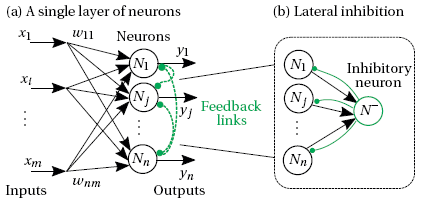

Source: *S. Woźniak, “Unsupervised Learning of Phase-Change-Based Neuromorphic Systems,” Doctoral dissertation, EPFL, 2017. Available:* https://infoscience.epfl.ch/record/232675

Single layer spiking neural network with feedback links (a) Excitatory neurons
$N_1, \dots, N_n$ are interconnected with feedback links, which foster divergent activity in the neurons.
(b) Feedback links often implement the lateral inhibition mechanism, in which an
additional inhibitory neuron $N^−$ inhibits the excitatory neurons.

## Implementation

Import the NeuroAIKit, load MNIST data and convert into spikes.

In [1]:
import neuroaikit as ai
import neuroaikit.tf as aitf

In [2]:
import tensorflow as tf

In [3]:
Ns = 20
max_rate_spikes = 6
# This may take several seconds to execute:
(train_x, train_y), (test_x, test_y) = tf.keras.datasets.mnist.load_data()
train_x = ai.utils.transform_rate(train_x.reshape(train_x.shape[0], -1) / 255.0, Ns, max_rate_spikes)
test_x = ai.utils.transform_rate(test_x.reshape(test_x.shape[0], -1) / 255.0, Ns, max_rate_spikes)
train_y = tf.keras.utils.to_categorical(train_y) # convert the labels to one-hot representation
test_y = tf.keras.utils.to_categorical(test_y)

To illustrate the operation of lateral inhibition, we run two models: `model` with standard SNUs and `li_model` with lateral inhibition enabled through `lateral_inhibition=True`:

In [27]:
config = {'decay': 0.9, 'g': aitf.activations.leaky_rel}
model = tf.keras.Sequential()
model.add(tf.keras.layers.InputLayer(input_shape=[None, 28*28]))
model.add(aitf.layers.SNU(100, **config, return_sequences=True))
model.add(aitf.layers.SNU(10, **config, return_sequences=True))
model.add(tf.keras.layers.GlobalAveragePooling1D())  # calculate averaged spiking rate

In [28]:
li_model = tf.keras.Sequential()
li_model.add(tf.keras.layers.InputLayer(input_shape=[None, 28*28]))
li_model.add(aitf.layers.SNU(100, **config, lateral_inhibition=True, return_sequences=True))
li_model.add(aitf.layers.SNU(10, **config, return_sequences=True))
li_model.add(tf.keras.layers.GlobalAveragePooling1D())  # calculate averaged spiking rate

We train both models for 5 epochs, and record the number of spikes:

In [32]:
epochs = 5

model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.1), loss='mse', metrics=['acc'])
model.add_metric(tf.reduce_sum(tf.reduce_mean(model.layers[0].output, axis=0)), 'spikes')
history = model.fit(train_x, train_y, epochs=epochs, batch_size=15)
metrics = model.evaluate(test_x, test_y)
print("SNN Loss {}, Accuracy {}, Spikes {}".format(*metrics))

li_model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.1), loss='mse', metrics=['acc'])
li_model.add_metric(tf.reduce_sum(tf.reduce_mean(li_model.layers[0].output, axis=0)), 'spikes')
li_history = li_model.fit(train_x, train_y, epochs=epochs, batch_size=15)
li_metrics = li_model.evaluate(test_x, test_y)
print("LI-SNN Loss {}, Accuracy {}, Spikes {}".format(*li_metrics))

Epoch 1/5
4000/4000 [==============================] - 30s 7ms/step - loss: 0.0255 - acc: 0.8828 - spikes: 640.6149
Epoch 2/5
4000/4000 [==============================] - 32s 8ms/step - loss: 0.0126 - acc: 0.9344 - spikes: 803.2480
Epoch 3/5
4000/4000 [==============================] - 30s 8ms/step - loss: 0.0113 - acc: 0.9416 - spikes: 966.3920
Epoch 4/5
4000/4000 [==============================] - 31s 8ms/step - loss: 0.0105 - acc: 0.9461 - spikes: 1049.0830
Epoch 5/5
313/313 [==============================] - 3s 7ms/step - loss: 0.0105 - acc: 0.9451 - spikes: 1128.2947
SNN Loss 0.01053647045046091, Accuracy 0.9451000094413757, Spikes 1128.294677734375
Epoch 1/5
4000/4000 [==============================] - 33s 8ms/step - loss: 0.0194 - acc: 0.8951 - spikes: 104.9134
Epoch 2/5
4000/4000 [==============================] - 31s 8ms/step - loss: 0.0138 - acc: 0.9273 - spikes: 55.4781
Epoch 3/5
4000/4000 [==============================] - 31s 8ms/step - loss: 0.0130 - acc: 0.9329 - spikes:

Obtained accuracy is comparable, but the number of spikes differs substantially.

## Activity comparison

Lateral inhibition reduces neural activity that results in fewer spikes emitted. We plot how the number of spikes changes during training:

Final test accuracy: SNN 0.9451 , LI-SNN 0.9382


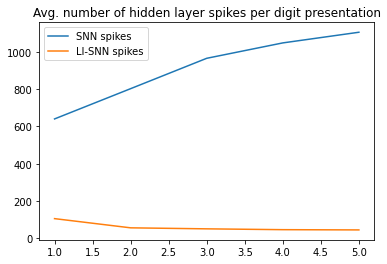

In [42]:
import matplotlib.pyplot as plt

h = history.history
epochs = range(1, len(h['acc'])+1)
li_h = li_history.history
li_epochs = range(1, len(li_h['acc'])+1)

plt.plot(epochs, h['spikes'], label='SNN spikes')
plt.plot(li_epochs, li_h['spikes'], label='LI-SNN spikes')
plt.title('Avg. number of hidden layer spikes per digit presentation')
plt.legend()

print('Final test accuracy: SNN {:.4f} , LI-SNN {:.4f}'.format(metrics[1], li_metrics[1]))

Lateral inhibition model is forced to operate with fewer spikes through the inhibition mechanism. Moreover, it learns to use it effectively to the model's advantage, that results in further reduction of the number of spikes at the end of training.

Standard model communicates between the layers using a larger number of spikes. Furthemore, it learns to use even more spikes, that results in further increase of the number of spikes at the end of training.

Observing the activity of the two models, the question is how it is possible that the two models have completely different propensity to use even less or even more spikes after the training is completed. Analysis of the features stored in neuronal weights provides some hints. 

## Features comparison

We display the features stored in the hidden layer weight matrices of both models:

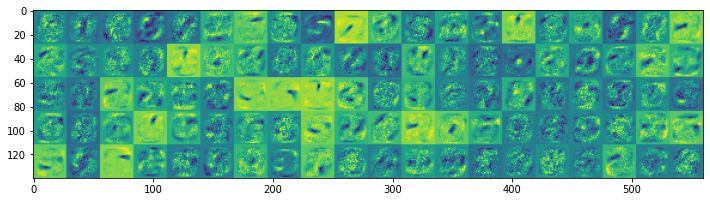

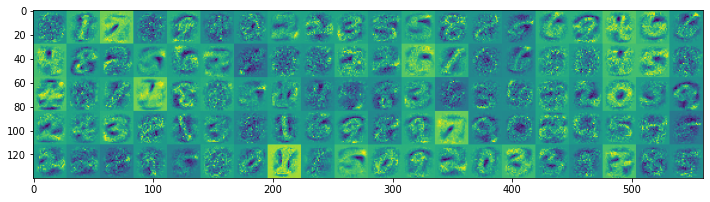

In [184]:
def normalize_per_neuron(M):
    W = M.weights[0].numpy()
    r = W.max(axis=0) - W.min(axis=0)
    W = ((W - W.min(axis=0)) / r)
    return W

plt.figure(figsize=(12,6))
plt.imshow(np.hstack(np.swapaxes(np.hstack(np.swapaxes(normalize_per_neuron(model).reshape([28,28,5,-1]),0,2)),0,2)))
plt.figure(figsize=(12,6))
plt.imshow(np.hstack(np.swapaxes(np.hstack(np.swapaxes(normalize_per_neuron(li_model).reshape([28,28,5,-1]),0,2)),0,2)))

Model without lateral inhibition starts to develop smaller-sized features, many of which are activated during digit presentation. Thus, even more spikes are used as the training progresses. On the other hand, the features in the model with lateral inhibition tend to be larger, thus fewer neurons become activated during the digit presentation.